In [48]:
from ipynb.fs.full.functions import clean_up, tokenize, stem_and_lemmatize, lemmatize,  remove_stopwords
import pandas as pd
import nltk
from pprint import pprint


In [2]:
import gensim
import gensim.corpora as corpora
import re
import spacy
from gensim.utils import simple_preprocess

In [3]:
instagram = pd.read_csv("instagram.csv")


## Topic Analysis - experiments

In [4]:
# inspired here https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Topic modeling is the process of identifying topics in a set of documents.Latent Dirichlet Allocation (LDA) is a probabilistic method for Topic Modelling.

In [5]:

data = instagram.post.tolist()
data[:10]



["the best offense is a good defense so here's some healthy tips on how to boast your immunity as work through this covid-19 scare.\n.\ndon't be scared, just take care.",
 'nature reflects back to us our own imbalance. when the health of the earth and ecosystems are compromised, our own health is also compromised. we are a part of nature, and her sickness becomes our sickness ~ her health, our health 🌏 art: @mimbirose    ',
 "concerning the current outbreak of covid-19 (coronavirus), which has now been declared as a pandemic, we must take precautions and safety measures to avoid its spread. even a simple handshake can cause the transfer of harmful disease-causing bacteria.\n\na safe way to greet others is through namaste, a customary and respectful indian greeting, which is also a part of atmantan's culture 🙏🏻   ",
 'lunch out today with my daughter😀 jacket potato with tuna and cheese hea and speedy salad 🥒🍅🥔2020',
 'whenever you are faced with fear, you always have a choice.\nfear is 

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'best', 'offense', 'is', 'good', 'defense', 'so', 'here', 'some', 'healthy', 'tips', 'on', 'how', 'to', 'boast', 'your', 'immunity', 'as', 'work', 'through', 'this', 'covid', 'scare', 'don', 'be', 'scared', 'just', 'take', 'care']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words])

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
# define stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'defense', 'healthy', 'tip', 'boast', 'immunity', 'work', 'scare', 'take', 'care']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [12]:
# term frequency
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('boast', 1),
  ('care', 1),
  ('defense', 1),
  ('good', 1),
  ('healthy', 1),
  ('immunity', 1),
  ('scare', 1),
  ('take', 1),
  ('tip', 1),
  ('work', 1)]]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
lda_model.print_topics()


[(0,
  '0.083*"often" + 0.056*"call" + 0.043*"risk" + 0.037*"leave" + 0.036*"reduce" + 0.036*"family" + 0.036*"home" + 0.031*"grow" + 0.031*"safe" + 0.029*"drop"'),
 (1,
  '0.150*"fat" + 0.139*"typically" + 0.107*"protein" + 0.083*"real" + 0.048*"deep" + 0.044*"cardio" + 0.041*"couple" + 0.023*"carbohydrate" + 0.021*"intense" + 0.019*"prefer"'),
 (2,
  '0.062*"perform" + 0.058*"celebration" + 0.042*"period" + 0.034*"breakfast" + 0.033*"growth" + 0.031*"however" + 0.029*"remove" + 0.027*"content" + 0.026*"natural" + 0.025*"complete"'),
 (3,
  '0.206*"lifestyle" + 0.183*"pain" + 0.084*"benefit" + 0.065*"able" + 0.043*"avoid" + 0.033*"continue" + 0.026*"die" + 0.019*"painful" + 0.016*"concern" + 0.016*"essential_oil"'),
 (4,
  '0.092*"health" + 0.079*"also" + 0.053*"include" + 0.051*"high" + 0.038*"level" + 0.033*"important" + 0.032*"increase" + 0.031*"nutrition" + 0.030*"sleep" + 0.029*"next"'),
 (5,
  '0.134*"low" + 0.099*"calorie" + 0.091*"balance" + 0.060*"study" + 0.047*"effect" + 0.

Topics still too "dispersed". Will use other paremeters to find more "solid" topics

## Fine tuning

In [15]:
# Build LDA model
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
lda_model2.print_topics()


[(0,
  '0.039*"healthy" + 0.031*"eat" + 0.025*"food" + 0.021*"follow" + 0.017*"lifestyle" + 0.012*"product" + 0.011*"add" + 0.010*"enjoy" + 0.010*"water" + 0.010*"make"'),
 (1,
  '0.091*"fibroid" + 0.035*"patient" + 0.033*"symptom" + 0.021*"surgery" + 0.021*"adenomyosis" + 0.020*"appointment" + 0.020*"follow" + 0.017*"cause" + 0.014*"often" + 0.014*"celebration"'),
 (2,
  '0.018*"day" + 0.018*"get" + 0.018*"make" + 0.016*"time" + 0.014*"want" + 0.014*"go" + 0.014*"know" + 0.012*"take" + 0.010*"feel" + 0.010*"life"'),
 (3,
  '0.078*"woman" + 0.030*"procedure" + 0.027*"ufe" + 0.024*"center" + 0.020*"workout" + 0.013*"set" + 0.012*"uterus" + 0.011*"age" + 0.010*"safe" + 0.009*"experience"'),
 (4,
  '0.018*"also" + 0.015*"help" + 0.011*"include" + 0.011*"pain" + 0.011*"high" + 0.010*"use" + 0.010*"perform" + 0.010*"may" + 0.009*"risk" + 0.008*"body"')]

#### With 5 topics:
- body
- disease (fibroid)
- diet advice / what to eat and what not
- positive / action verbs e.g. make, go, etc
- workout / program 

In [17]:
# tuning trying different passes, etc

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
lda_model.print_topics()

[(0,
  '0.038*"healthy" + 0.031*"eat" + 0.025*"food" + 0.021*"follow" + 0.017*"lifestyle" + 0.012*"product" + 0.011*"add" + 0.010*"enjoy" + 0.010*"make" + 0.010*"water"'),
 (1,
  '0.085*"fibroid" + 0.033*"patient" + 0.031*"symptom" + 0.022*"follow" + 0.020*"surgery" + 0.020*"adenomyosis" + 0.019*"appointment" + 0.016*"cause" + 0.015*"celebration" + 0.014*"women_leader"'),
 (2,
  '0.019*"day" + 0.018*"get" + 0.018*"make" + 0.016*"time" + 0.014*"want" + 0.014*"go" + 0.014*"know" + 0.012*"take" + 0.011*"feel" + 0.010*"life"'),
 (3,
  '0.076*"woman" + 0.028*"procedure" + 0.025*"ufe" + 0.022*"center" + 0.020*"workout" + 0.013*"set" + 0.012*"uterus" + 0.011*"age" + 0.010*"safe" + 0.009*"yoga"'),
 (4,
  '0.018*"also" + 0.015*"help" + 0.011*"include" + 0.011*"high" + 0.010*"use" + 0.010*"pain" + 0.010*"perform" + 0.010*"may" + 0.009*"body" + 0.009*"risk"')]

#### 5 topics
- body, help with body issues? food and exercise
- disease
- recipes
- action verbs
- workout program

In [19]:
# keeping nouns only

from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)
            

In [20]:
data_nouns = instagram["post"].apply(str).apply(nouns)
data_nouns[:10]

0        offense defense tips immunity work scare care
1    nature imbalance health earth ecosystems healt...
2    outbreak covid-19 coronavirus precautions safe...
3    lunch today daughter😀 jacket potato tuna hea s...
4    fear choice fear something something needs pow...
5    c k lot antioxidants oxidation skin radicals a...
6    gift time i m go @ revivesuperfoods time break...
7    coronavirus please safety measures day everyon...
8    mani-pedis 🥰 risks health infection contact de...
9    y'all i morning person day mom struggle body c...
Name: post, dtype: object

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_nouns)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['offense', 'defense', 'tip', 'immunity', 'work', 'care']]


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [23]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('care', 1),
  ('defense', 1),
  ('immunity', 1),
  ('offense', 1),
  ('tip', 1),
  ('work', 1)]]

In [40]:


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
lda_model.print_topics()


[(0,
  '0.065*"fibroid" + 0.060*"woman" + 0.034*"symptom" + 0.032*"procedure" + 0.021*"surgery" + 0.021*"appointment" + 0.016*"adenomyosis" + 0.014*"center" + 0.013*"workout" + 0.012*"fibroid_center"'),
 (1,
  '0.037*"water" + 0.028*"option" + 0.025*"oil" + 0.025*"tip" + 0.024*"link" + 0.017*"bio" + 0.016*"heart" + 0.015*"meal" + 0.014*"drink" + 0.014*"recipe"'),
 (2,
  '0.037*"body" + 0.026*"food" + 0.024*"patient" + 0.018*"health" + 0.017*"pain" + 0.015*"weight" + 0.013*"exercise" + 0.012*"loss" + 0.011*"morning" + 0.011*"risk"'),
 (3,
  '0.039*"celebration" + 0.037*"world_hub" + 0.037*"women_leader" + 0.037*"twitter_com" + 0.037*"acelebrationofw" + 0.029*"period" + 0.016*"protein" + 0.015*"estrogen" + 0.015*"breakfast" + 0.015*"delivery"'),
 (4,
  '0.051*"time" + 0.046*"day" + 0.029*"year" + 0.028*"life" + 0.027*"people" + 0.025*"today" + 0.024*"thing" + 0.022*"goal" + 0.021*"week" + 0.016*"friend"')]

#### Topics if only accounting for nouns (above)
- food, female topics (period, estrogen)
- woman, leadership
- recipe?
- disease, medical procedures
- symptom/pain


In [26]:
# reducing chunksize

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
lda_model.print_topics()


[(0,
  '0.091*"woman" + 0.041*"food" + 0.036*"thing" + 0.032*"week" + 0.023*"exercise" + 0.023*"water" + 0.019*"option" + 0.017*"question" + 0.017*"lot" + 0.015*"fruit"'),
 (1,
  '0.096*"fibroid" + 0.051*"symptom" + 0.049*"procedure" + 0.022*"adenomyosis" + 0.019*"treatment" + 0.017*"tip" + 0.017*"fibroids" + 0.017*"fibroid_center" + 0.016*"oil" + 0.013*"condition"'),
 (2,
  '0.032*"patient" + 0.031*"year" + 0.023*"surgery" + 0.021*"appointment" + 0.019*"pain" + 0.016*"minute" + 0.015*"work" + 0.014*"center" + 0.014*"loss" + 0.013*"risk"'),
 (3,
  '0.025*"blood" + 0.023*"product" + 0.015*"routine" + 0.015*"recipe" + 0.014*"protein" + 0.014*"drink" + 0.014*"eye" + 0.014*"breakfast" + 0.014*"fat" + 0.013*"fiber"'),
 (4,
  '0.050*"time" + 0.042*"day" + 0.038*"body" + 0.027*"people" + 0.027*"life" + 0.023*"today" + 0.021*"goal" + 0.019*"health" + 0.018*"way" + 0.016*"weight"')]

### Topics when chunkside is reduced (above)
- procedure, treatment
- woman, life
- fruit, plann
- disease, symptom
- day, food


In [28]:
# chunkside back to 100, passes 50, 4 topics

In [29]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
lda_model.print_topics()



[(0,
  '0.050*"food" + 0.039*"week" + 0.029*"exercise" + 0.028*"water" + 0.021*"celebration" + 0.021*"question" + 0.020*"link" + 0.020*"women_leader" + 0.020*"world_hub" + 0.020*"acelebrationofw"'),
 (1,
  '0.029*"tip" + 0.027*"oil" + 0.016*"size" + 0.016*"picture" + 0.016*"recipe" + 0.014*"drop" + 0.013*"veggie" + 0.012*"minute" + 0.011*"value" + 0.011*"tea"'),
 (2,
  '0.033*"time" + 0.028*"day" + 0.021*"body" + 0.018*"year" + 0.018*"people" + 0.017*"life" + 0.015*"thing" + 0.015*"today" + 0.014*"goal" + 0.011*"way"'),
 (3,
  '0.051*"fibroid" + 0.044*"woman" + 0.027*"symptom" + 0.026*"procedure" + 0.024*"patient" + 0.017*"surgery" + 0.016*"appointment" + 0.015*"pain" + 0.012*"adenomyosis" + 0.011*"center"')]

### with 4 topics
- woman, food, weight, ageing
- day, year, goal - probably resolutions
- ?
- disease, procedure

In [31]:
# 3 topics
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
lda_model3.print_topics()


[(0,
  '0.057*"fibroid" + 0.049*"woman" + 0.030*"symptom" + 0.029*"procedure" + 0.027*"patient" + 0.019*"surgery" + 0.018*"appointment" + 0.016*"pain" + 0.013*"adenomyosis" + 0.012*"center"'),
 (1,
  '0.026*"water" + 0.017*"fruit" + 0.014*"food" + 0.014*"calorie" + 0.011*"recipe" + 0.010*"oil" + 0.010*"meal" + 0.010*"protein" + 0.010*"drink" + 0.010*"breakfast"'),
 (2,
  '0.025*"time" + 0.021*"day" + 0.019*"body" + 0.014*"year" + 0.013*"people" + 0.013*"life" + 0.011*"thing" + 0.011*"today" + 0.011*"goal" + 0.010*"week"')]

### 3 topics (above)

- diet/food: water, recipe, protein
- resolution: the healthy life, decisions, woman
- diseases: fibroid, woman, procedure, treatment, pain, opinion



### Model Perplexity and Coherence Score

In [33]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model3, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.55584367459011


In [34]:
# coherence score is anything between 0 and 1. 1 being good.


### Visualisation

In [35]:
# libraries
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.176967  0.252830       1        1  66.668343
1     -0.139374 -0.273687       2        1  20.942719
0      0.316341  0.020857       3        1  12.388936, topic_info=     Category         Freq         Term        Total  loglift  logprob
5858  Default  1000.000000      fibroid  1000.000000  30.0000  30.0000
725   Default  1168.000000        woman  1168.000000  29.0000  29.0000
179   Default   783.000000        water   783.000000  28.0000  28.0000
643   Default   532.000000      symptom   532.000000  27.0000  27.0000
1263  Default   515.000000    procedure   515.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
725    Topic3   858.638000        woman  1168.806641   1.7800  -3.0170
534    Topic3   145.874878  celebration   250.244904   1.5487  -4.7896
226    Topic3   156.602493       period   289.324310   1.4745  -4.7187
1109   Topic3   112.640678       doctor   227.860947   1.3838  -5.0482
1444   Topic3   104.583466      opinion   222.960815   1.3314  -5.1224

[145 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
9249       1  0.012881         ablation
9249       3  0.978931         ablation
10422      1  0.022855  acelebrationofw
10422      3  0.977046  acelebrationofw
9250       3  0.997301      adenomyosis
...      ...       ...              ...
5          1  0.999475             work
1307       1  0.998269          workout
2505       1  0.022855        world_hub
2505       3  0.977059        world_hub
146        1  0.999579             year

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

### Conclusion
Afer experimenting with different parameters, 3 topics seems to give us a solid idea of the different existent topics founds in the instagram posts. 
This might need to be changed/ further "tuned" if more data becomes available.


In [37]:
type(lda_model3)

gensim.models.ldamodel.LdaModel

### Bulding LDA Mallet Model

LDA Mallet Model often gives a better quality of topics

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


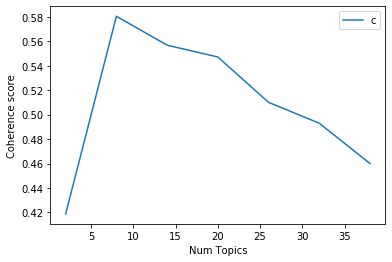

In [54]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### compute Mallet Model with 9 topics 

In [74]:
ldamallet_9 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=9, id2word=id2word)

In [75]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet_9, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score for 9 topics: ', coherence_ldamallet)


Coherence Score for 9 topics:  0.5361029124406793


### with 12 topics

In [78]:
ldamallet_12 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [79]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet_12, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5574245816475133


### 15 topics

In [81]:
ldamallet_15 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

In [82]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet_15, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.607610864890802


### 20 topics

In [84]:
ldamallet_20 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [85]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet_20, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.538871047937976


15 topics seems to be the best option here

In [94]:
# Select the model and print the topics
optimal_model = ldamallet_15
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(0,
  '0.075*"friend" + 0.059*"share" + 0.053*"family" + 0.035*"post" + '
  '0.032*"world"'),
 (1,
  '0.063*"calorie" + 0.058*"water" + 0.051*"protein" + 0.032*"sugar" + '
  '0.030*"fat"'),
 (2,
  '0.059*"woman" + 0.031*"fibroid" + 0.027*"symptom" + 0.027*"pain" + '
  '0.022*"risk"'),
 (3,
  '0.133*"year" + 0.058*"month" + 0.055*"program" + 0.054*"live" + '
  '0.043*"love"'),
 (4,
  '0.110*"people" + 0.068*"life" + 0.055*"thing" + 0.037*"mind" + '
  '0.027*"person"'),
 (5,
  '0.051*"recipe" + 0.036*"ingredient" + 0.032*"minute" + 0.022*"lunch" + '
  '0.017*"egg"'),
 (6,
  '0.080*"goal" + 0.079*"weight" + 0.058*"change" + 0.048*"result" + '
  '0.045*"challenge"'),
 (7,
  '0.188*"day" + 0.058*"level" + 0.043*"stuff" + 0.042*"today" + '
  '0.040*"website"'),
 (8,
  '0.158*"time" + 0.091*"week" + 0.087*"day" + 0.076*"today" + '
  '0.058*"morning"'),
 (9,
  '0.175*"body" + 0.036*"health" + 0.031*"system" + 0.030*"benefit" + '
  '0.023*"vitamin"'),
 (10,
  '0.052*"exercise" + 0.045*"workout

In [ ]:
# adding keywrods to dataframe 

In [96]:
def format_topics_sentences(ldamodel=ldamallet_15, corpus=corpus, texts=data_nouns):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.1111,"link, bio, tip, celebration, credit, women_lea...",the best offense is a good defense so here's s...
1,1,13.0,0.1073,"product, skin, oil, night, hand, sleep, order,...",nature reflects back to us our own imbalance. ...
2,2,2.0,0.1004,"woman, fibroid, symptom, pain, risk, patient, ...",concerning the current outbreak of covid-19 (c...
3,3,5.0,0.0988,"recipe, ingredient, minute, lunch, egg, place,...",lunch out today with my daughter😀 jacket potat...
4,4,11.0,0.1111,"thing, time, life, health, heart, lot, care, c...","whenever you are faced with fear, you always h..."
5,5,13.0,0.1248,"product, skin, oil, night, hand, sleep, order,...",who doesn't love cucumber? it’s high in vitami...
6,6,13.0,0.1063,"product, skin, oil, night, hand, sleep, order,...",gift time! (swipe) i’m always on the go and @r...
7,7,0.0,0.1354,"friend, share, family, post, world, comment, t...",scared of coronavirus? please don't worry take...
8,8,12.0,0.1057,"link, bio, tip, celebration, credit, women_lea...",who doesn't love mani-pedis? 💅\nnot only does ...
9,9,13.0,0.1209,"product, skin, oil, night, hand, sleep, order,...",y'all know that i am not a morning person. giv...


In [ ]:
# add date to the above

In [97]:
df_dominant_topic.shape

(13032, 5)

In [98]:
instagram.shape

(13032, 7)

In [100]:
df_dominant_topic['Date'] = instagram['timestamp'].values

In [102]:
instagram_topics = df_dominant_topic

In [103]:
instagram_topics.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date
0,0,12.0,0.1111,"link, bio, tip, celebration, credit, women_lea...",the best offense is a good defense so here's s...,2020-03-12T14:32:48.000Z
1,1,13.0,0.1073,"product, skin, oil, night, hand, sleep, order,...",nature reflects back to us our own imbalance. ...,2020-03-12T14:22:34.000Z
2,2,2.0,0.1004,"woman, fibroid, symptom, pain, risk, patient, ...",concerning the current outbreak of covid-19 (c...,2020-03-12T14:17:54.000Z
3,3,5.0,0.0988,"recipe, ingredient, minute, lunch, egg, place,...",lunch out today with my daughter😀 jacket potat...,2020-03-12T14:17:02.000Z
4,4,11.0,0.1111,"thing, time, life, health, heart, lot, care, c...","whenever you are faced with fear, you always h...",2020-03-12T14:01:39.000Z


In [106]:
instagram_topics.to_csv("/Users/ana/ironhack_coding/projects/final_project/final-project/datasets/instagram_topics.csv")